In [34]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import MiniBatchKMeans

In [289]:
folder = 'InSample1/2'

files = os.listdir(folder)
pics = {}
kpics = {}

PERCENTILE_CUTOFF = 50


for filee in files:
    image = cv2.imread(folder + "/" + filee)
    image = cv2.resize(image,None,fx=0.25,fy=0.25)

    pics[filee.split(".")[0]] = image
    kpics[filee.split(".")[0]] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("All Images Read.")

All Images Read.


In [290]:
kp = {}
des = {}

nkp = {}
ndes = {}

for key, value in kpics.items():
    print("Extracting all features for Image {}".format(key))
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(kpics[key], None)
    kp[key] = keypoints
    des[key] = descriptors
    
    kp_coordinates = np.array([list(i.pt) for i in keypoints])

    new_descriptors = np.block([descriptors, kp_coordinates])

    print("Finding unique features out of total {} keypoints from Image {}".format(len(kp[key]), key))
    kmeans = MiniBatchKMeans(n_clusters=len(kp[key]) / 100, random_state=0, batch_size = len(kp[key]) / 100).fit(new_descriptors)

    clusters = kmeans.labels_
    distances = np.sqrt(np.sum((new_descriptors - kmeans.cluster_centers_[clusters]) ** 2, axis = 1))

    percentile = np.percentile(distances, PERCENTILE_CUTOFF)
    ndes[key] = des[key][distances > percentile]
    nkp[key] = list(np.array(kp[key])[distances > percentile])
    
des = ndes
kp = nkp

print("Finding unique features done.")

Extracting all features for Image 1
Finding unique features out of total 1307 keypoints from Image 1
Extracting all features for Image 9
Finding unique features out of total 663 keypoints from Image 9
Extracting all features for Image 3
Finding unique features out of total 1114 keypoints from Image 3
Extracting all features for Image 2
Finding unique features out of total 1400 keypoints from Image 2
Finding unique features done.


In [291]:
print("Feature matching among all pairs of Images starting.")

matches_dict = {}
total_matches = []


for i in kpics.keys():
    matches_dict[i] = {}

    for j in kpics.keys():
        if i != j:
            key1 = i
            key2 = j
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50)   # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)
            matches = flann.knnMatch(des[key1],des[key2],k=2)
            matchesMask = [[0,0] for _ in range(len(matches))]
            good_matches = []
            for m,n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
            matches = good_matches        
            matches = sorted(matches, key = lambda x:x.distance)
            
            if len(matches) > 200:
                matches = matches[:200]
            matches_dict[i][j] = matches
            total_matches += matches
            
            print("Between {} and {}, number of good matches: {}".format(i, j, len(matches)))

average_matches_per_pair = 2 * len(total_matches) / (len(matches_dict) ** 2 - len(matches_dict))

match_distances = [match.distance for match in total_matches]

print(100 / (len(kpics) - 1))

percentile_matches = np.percentile(match_distances, 100 / (len(kpics) - 1))

print("Feature Matching Done For all Images, Distance to beat: {}".format(percentile_matches))

Feature matching among all pairs of Images starting.
Between 1 and 9, number of good matches: 14
Between 1 and 3, number of good matches: 57
Between 1 and 2, number of good matches: 90
Between 9 and 1, number of good matches: 15
Between 9 and 3, number of good matches: 42
Between 9 and 2, number of good matches: 12
Between 3 and 1, number of good matches: 51
Between 3 and 9, number of good matches: 36
Between 3 and 2, number of good matches: 22
Between 2 and 1, number of good matches: 97
Between 2 and 9, number of good matches: 10
Between 2 and 3, number of good matches: 21
33
Feature Matching Done For all Images, Distance to beat: 143.97400177


In [292]:
average_matches_per_pair

77

In [294]:
MIN_MATCH_COUNT=  10

print(MIN_MATCH_COUNT)
best_match = {}
best_match_count = {}
good_matches_dict = {}

for key in kpics.keys():
    best_match_count[key] = 0

order = {}
for i in kpics.keys():
    good_matches_dict[i] = {} 
    for j in kpics.keys():
        if i != j:
            good_matches_dict[i][j] = []
            for match in matches_dict[i][j]:
                if match.distance < percentile_matches:
                    good_matches_dict[i][j].append(match)
             
            good_matches = good_matches_dict[i][j]
            print("Between {} and {}".format(i, j))
            print(len(good_matches))
            
            if len(good_matches) >= MIN_MATCH_COUNT:
                img1, img2, kp1, kp2 = kpics[i], kpics[j], kp[i], kp[j]
                cimg1, cimg2 = pics[i], pics[j]
                
                img1_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                img2_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)                
                H1, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC,8, maxIters=2000)

                if type(H1) != type(None) and H1[0][2] > 0:
                    H2, mask = cv2.findHomography(img2_pts, img1_pts, cv2.RANSAC,8, maxIters=2000)

                    H2_inverse = np.linalg.inv(H2)

                    H = (H1 + H2_inverse) / 2.
                    H = H1
                    
                    if len(good_matches) > best_match_count[j]:
                        best_match[j] = (i, H)
                        best_match_count[j] = len(good_matches)
                        order[j] = i

                    
print(best_match)
print(order)

10
Between 1 and 9
0
Between 1 and 3
15
Between 1 and 2
41
Between 9 and 1
2
Between 9 and 3
12
Between 9 and 2
1
Between 3 and 1
18
Between 3 and 9
13
Between 3 and 2
5
Between 2 and 1
41
Between 2 and 9
1
Between 2 and 3
5
{'9': ('3', array([[ 2.97413352e-01, -5.77285910e-03,  6.08605458e+02],
       [-1.54035621e-01,  8.68905527e-01,  1.74139279e+01],
       [-7.23384223e-04,  7.20610618e-05,  1.00000000e+00]])), '1': ('2', array([[ 5.43007077e-01,  1.14590555e-01,  3.87336003e+02],
       [-1.15984259e-01,  9.19262429e-01,  2.61982018e+01],
       [-4.83199299e-04,  1.39112275e-04,  1.00000000e+00]])), '3': ('1', array([[ 5.13088819e-01,  8.51091822e-03,  4.46513145e+02],
       [-1.11491171e-01,  8.71013981e-01,  2.84750325e+01],
       [-4.62891217e-04,  3.80131593e-05,  1.00000000e+00]]))}
{'9': '3', '1': '2', '3': '1'}


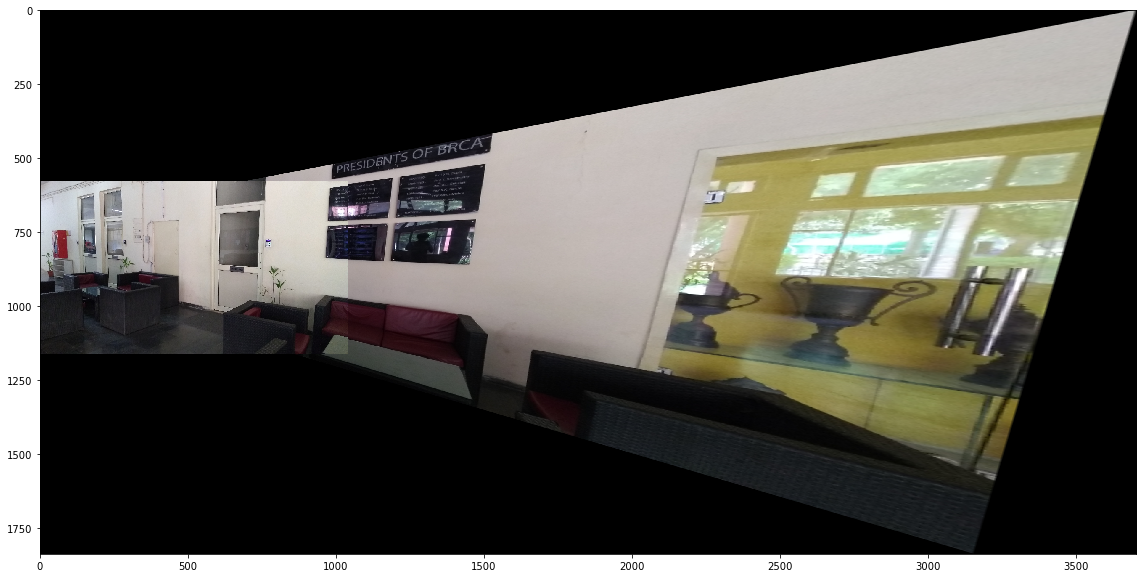

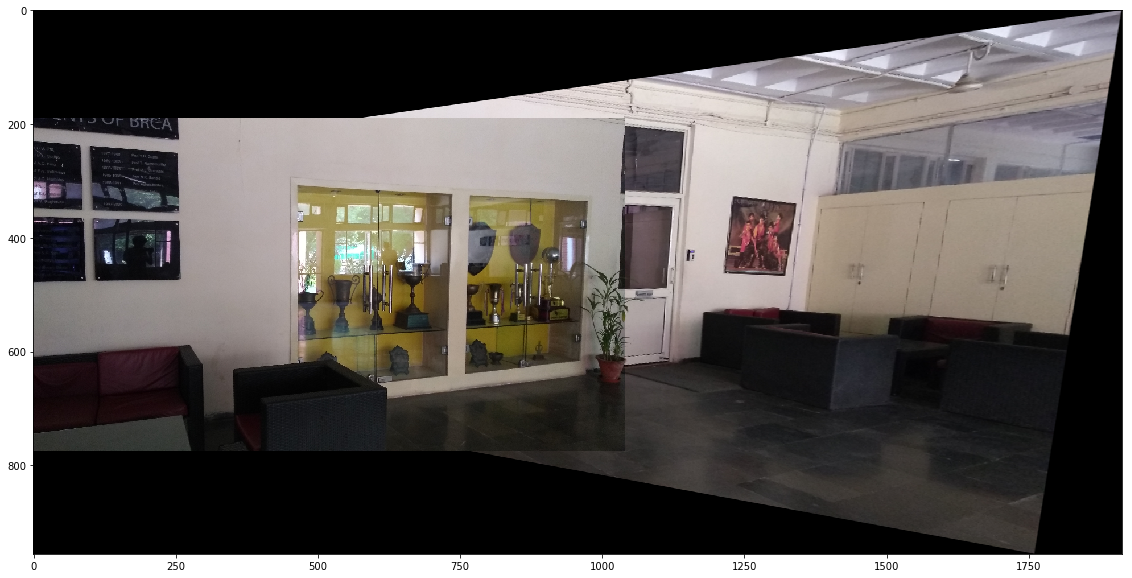

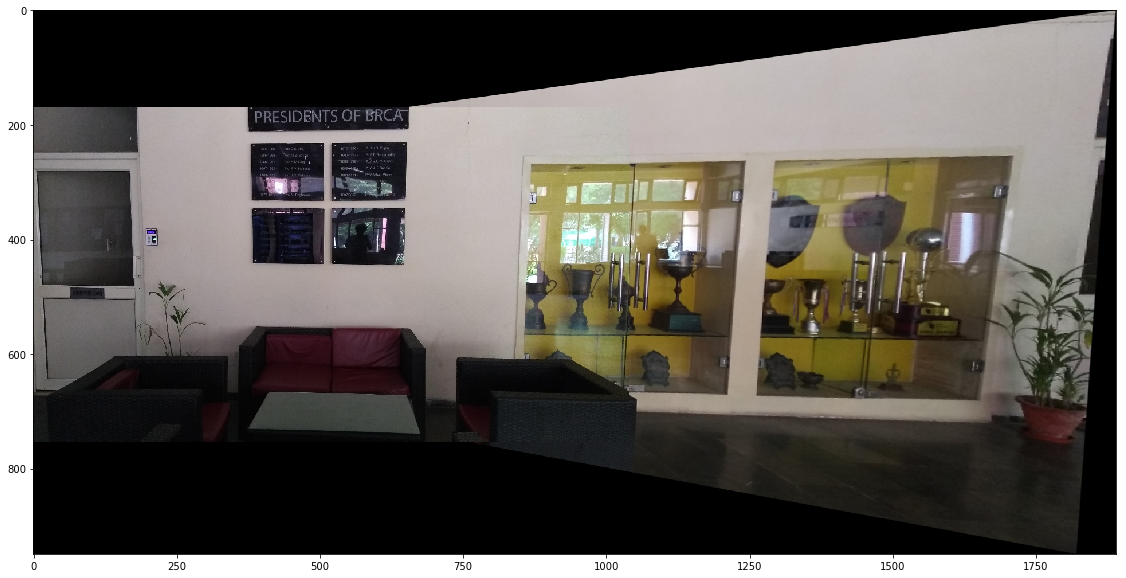

In [295]:
for key in best_match.keys():
    match, H = best_match[key]
    
    img1, img2 = pics[match], pics[key]
    
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)


    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    t = [-xmin,-ymin]

    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2
                    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                    
    plt.figure(figsize=(20, 10))
    plt.imshow(result)
    plt.show()

In [253]:
for key in order.keys():
    if key not in order.values():
        starting_frame = key
        
reverse_order = {}
for key in order.keys():
    value = order[key]
    reverse_order[value] = key
    
# print(reverse_order)

key = starting_frame
# key = "2"
num = 0
order_list = [key]

bm = {}

bm[key] = np.eye(3)

while key in best_match.keys():
    match, H = best_match[key]
    print(key, match)
    bm[match] = np.dot(bm[key], H)
    key = match
    order_list.append(key)
    

# print(bm["3"])

('1', '8')
('8', '3')
('3', '5')


5
[[[2538.3792   -377.4334  ]]

 [[2810.5815   1090.4868  ]]

 [[-261.2829    668.4557  ]]

 [[-221.1721     10.316116]]]
(-261, -377, 2811, 1090)
(3072, 1467)


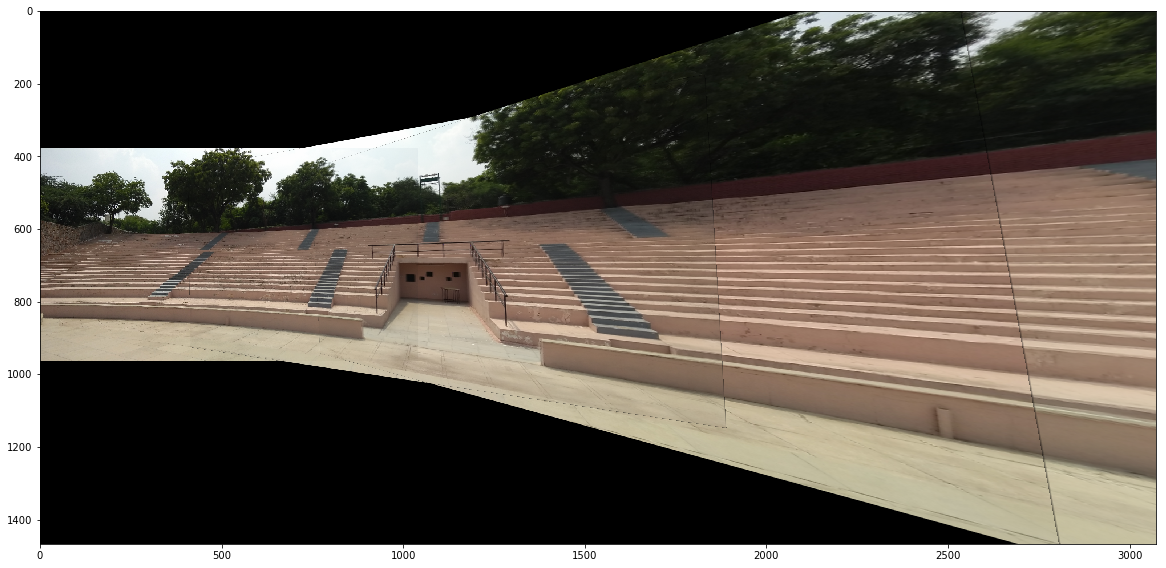

In [254]:
last = -1

img2 = pics[order_list[last]]
img1 = pics[order_list[0]]

print(order_list[last])
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]

pts1 = np.float32([[0,0],[0,h1],[w1,0],[w1,h1]]).reshape(-1, 1, 2)
pts2 = np.float32([[0,0],[0,h2],[w2,0],[w2,h2]]).reshape(-1, 1, 2)


pts2_t = cv2.perspectiveTransform(pts2, bm[order_list[last]])
pts = np.concatenate((pts1, pts2_t), axis=0)

# print(pts1)
print(pts2_t)

[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
print(xmin, ymin, xmax, ymax)

Ht = np.reshape(np.array([1, 0, 0, 0, 1, -ymin, 0, 0, 1]), (3, 3))

dsize = (xmax - xmin, ymax - ymin)
print(dsize)
result2 = cv2.warpPerspective(img2, Ht.dot(bm[order_list[last]]), dsize)
present2 = (result2 != 0).astype(np.int8)

result1 = cv2.warpPerspective(img1, Ht.dot(np.eye(3)), dsize)
present1 = (result1 != 0).astype(np.int8)

result = result1 * present1 + result2 * present2
present = present1 + present2

for i in order_list[1:last]:
    img3 = pics[i]
    result3 = cv2.warpPerspective(img3, Ht.dot(bm[i]), dsize)
    present3 = (result3 != 0).astype(np.int8)
    
    result = result + result3 * present3
    present = present + present3
    
result = result / (present + 0.0001)

result = result.astype(np.uint8)
                  
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                    
plt.figure(figsize=(20, 10))
plt.imshow(result)
plt.show()